## APhys Group Meeting, 25.02.2026

microCTD and CTD campaign from 13.02.2026.

In [8]:
# imports
import ewgreaders as ewg
import xarray as xr
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from glob import glob
import os

### Profile Locations

In [4]:
def plot_profiles_map_bathy(profile_locs, bathy):
    # don't doule plot duplicates
    profile_locs = profile_locs.drop_duplicates(subset='name')

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 7), width_ratios=[1.2, 1])

    # map
    im = ax[0].pcolormesh(bathy['xsc'], bathy['ysc'], bathy['depth'], cmap='Greys_r', vmin=0)
    cbar = fig.colorbar(im, shrink=0.7, label='Depth [m]', location='left', pad=0.13, ax=ax[0])
    cbar.ax.invert_yaxis()

    # bathymetry
    sns.lineplot(profile_locs, x='ysc', y='total_depth', marker='o', ax=ax[1])
    
    # profile locations
    for _, p in profile_locs.iterrows():
        ax[0].scatter(p['xsc'], p['ysc'], c='steelblue', edgecolor='black', marker='o')
        ax[0].annotate(p['name'], (p['xsc'], p['ysc']), color='red', xytext=(3,0), textcoords='offset points')
        ax[1].annotate(p['name'], (p['ysc'], p['total_depth']), color='red', xytext=(0,5), textcoords='offset points')
        

    ax[1].set_xlabel('Y Swiss Coordinate')
    ax[1].set_ylabel('Depth [m]')

    ax[1].set_ylim(0, 205)
    ax[1].invert_xaxis()
    ax[1].invert_yaxis()
    ax[1].grid()
    ax[1].spines[['right', 'top']].set_visible(False)

    plt.tight_layout(w_pad=2)
    plt.show()

In [150]:
lake = 'Zugersee'
year = '2026'

mctd_locs = pd.DataFrame({
    'name': ['VMPS','VMPC', 'VMPW', 'VMPN'],
    'xsc': [680442, 680105, 679911, 679250],
    'ysc': [216834, 218781, 218799, 220433]
})

mctd_locs['xsc'] += int(2e6)
mctd_locs['ysc'] += int(1e6)

bathy = xr.open_dataset('Q:/Messdaten/Aphys_Hypothesis_data/Zugersee/bathymetry.nc')
mctd_locs['total_depth'] = [bathy.sel(xsc=row.xsc, ysc=row.ysc).depth.item() for _, row in mctd_locs.iterrows()]

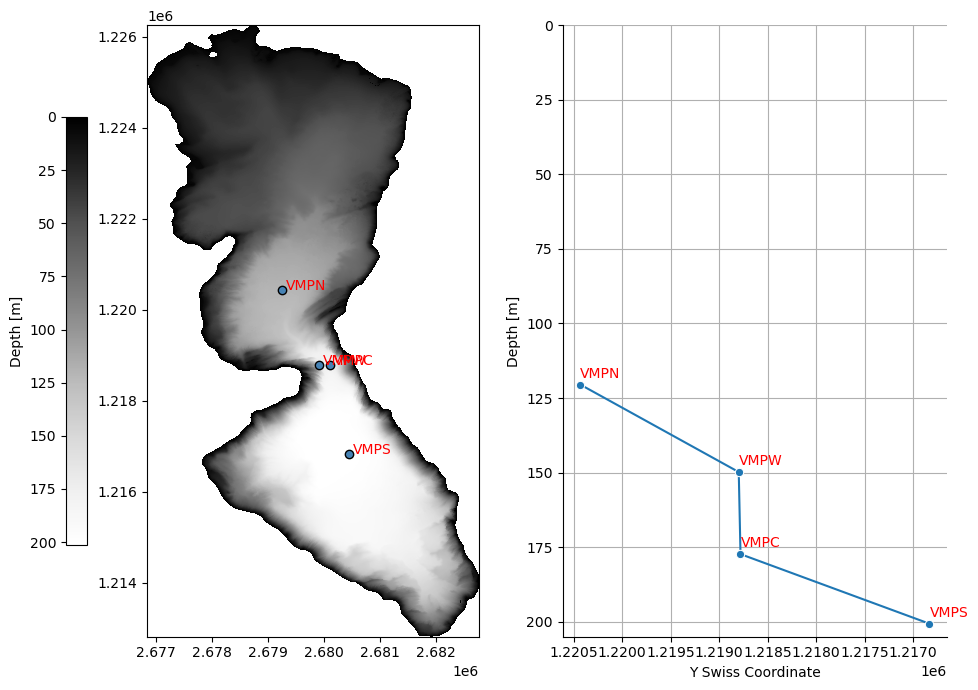

In [151]:
plot_profiles_map_bathy(mctd_locs, bathy)

### microCTD

In [152]:
date = f'{year}0213'
dpath_L2 = f'Q:/Messdaten/Aphys_Hypothesis_data/{lake}/{year}/Microstructure/{date}/Level2/'
fpaths = glob(f'{dpath_L2}*.nc')

In [153]:
all_ds = []
for fpath in fpaths:
    if 'DAT_091' in fpath or 'DAT_092' in fpath:
        name = 'VMPN'
    elif 'DAT_093' in fpath:
        name = 'VMPC'
    elif 'DAT_094' in fpath:
        name = 'VMPW'
    elif 'DAT_095' in fpath:
        name = 'VMPS'
    else:
        continue

    all_ds.append((name, xr.open_dataset(fpath)))

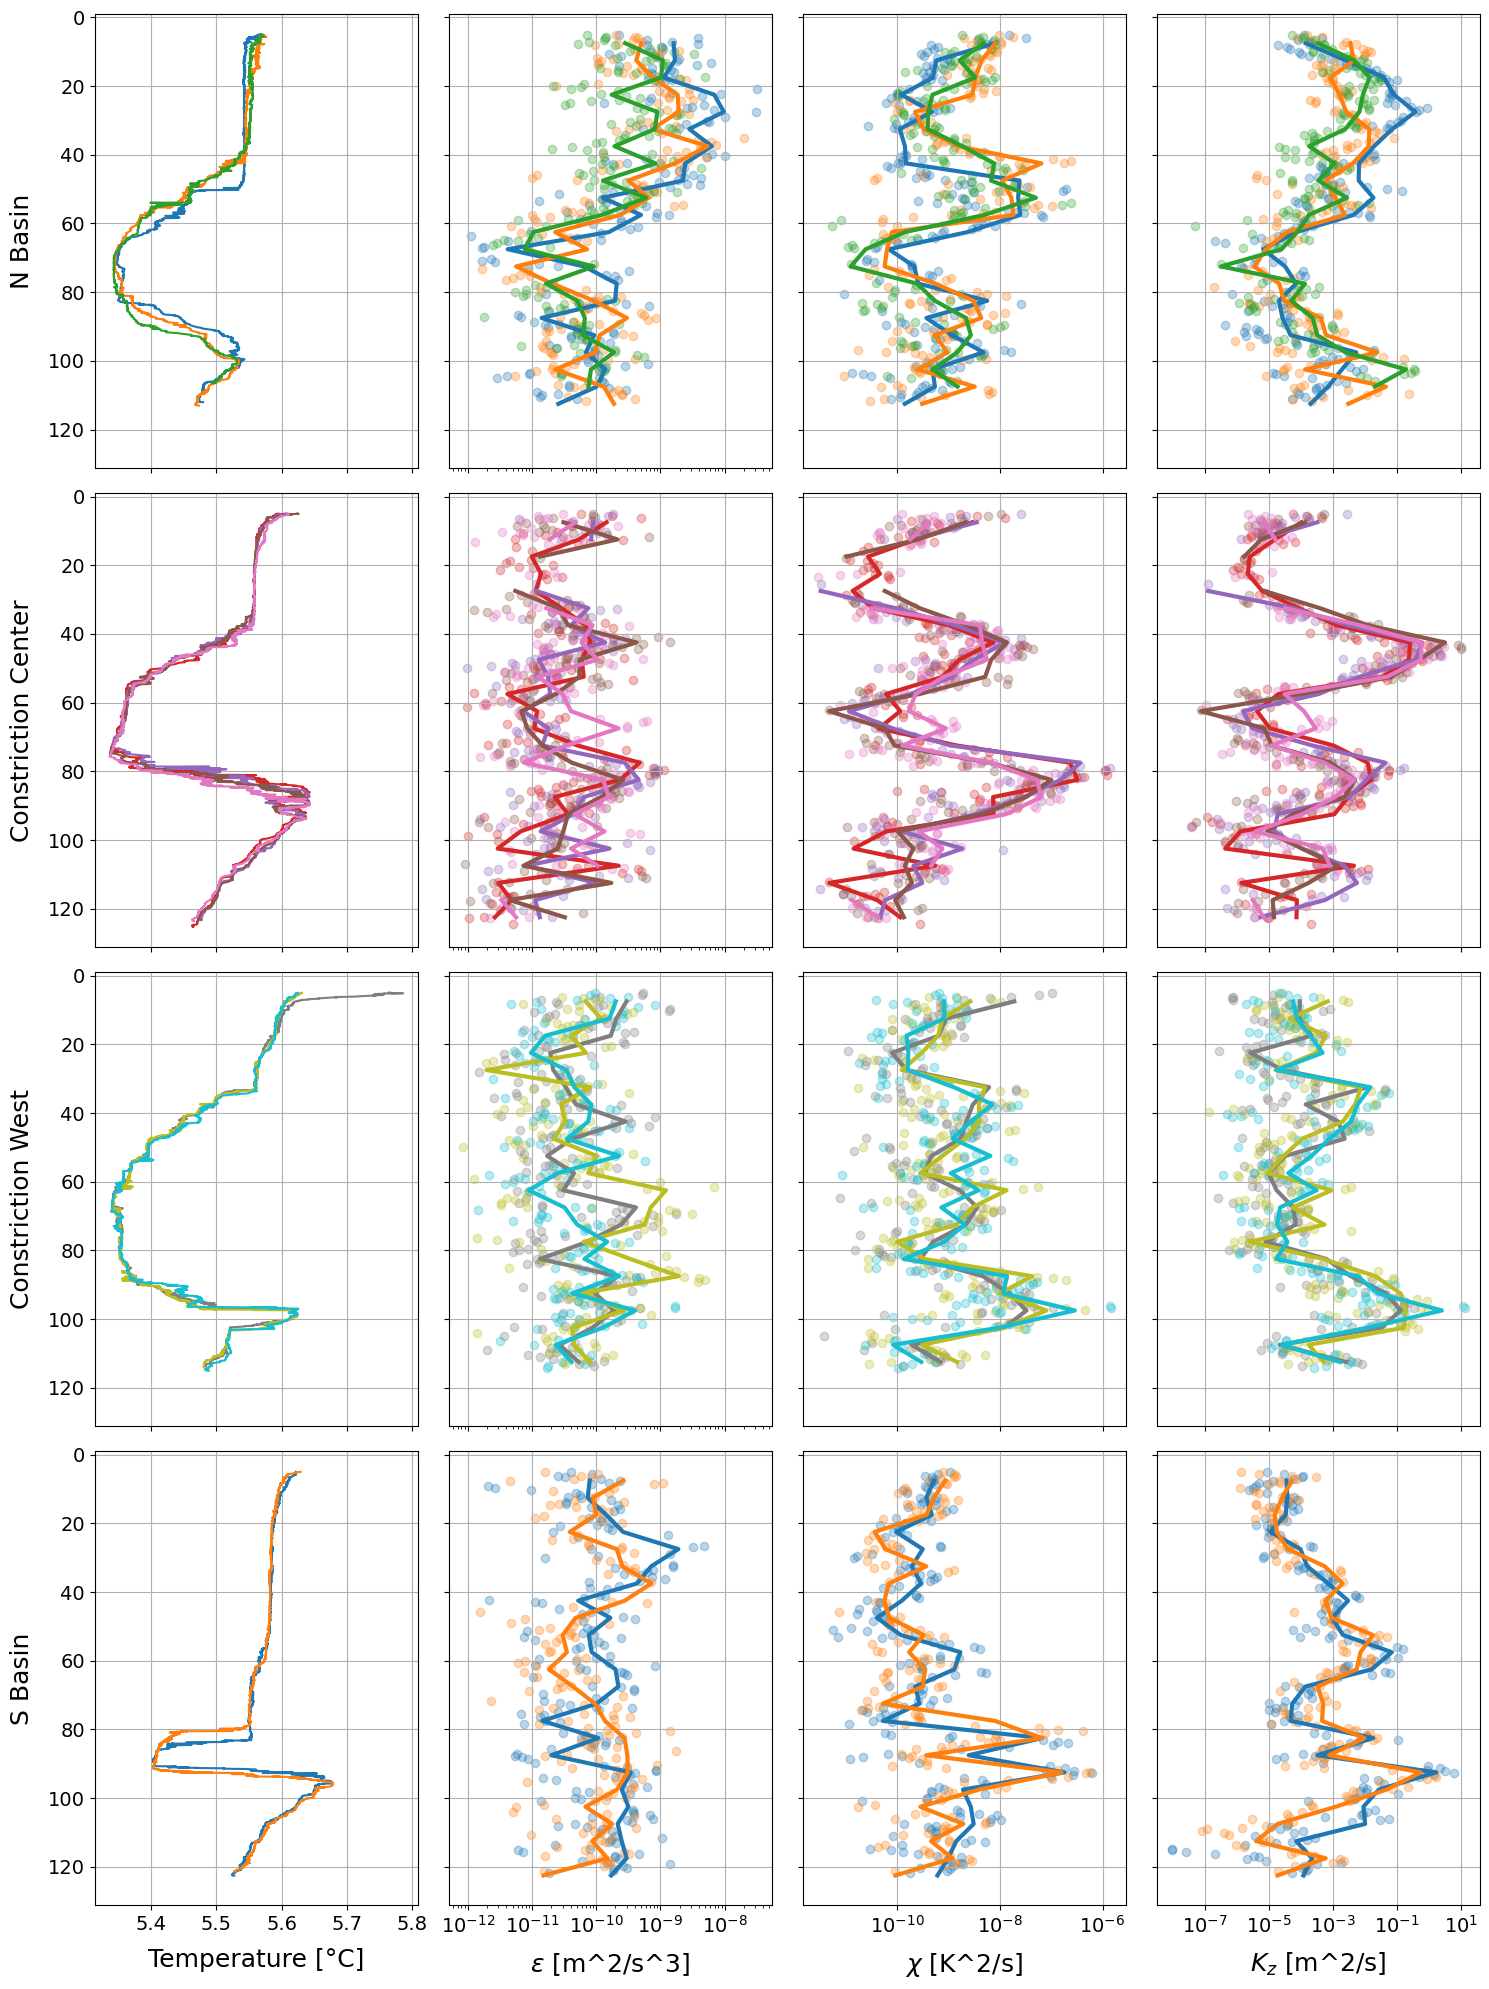

In [ ]:
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(15, 20), sharey=True, sharex='col')
palette = sns.color_palette('tab10', n_colors=len(all_ds))

for p, (name, ds) in enumerate(all_ds):
    color = palette[p]
    if name == 'VMPN':
        i = 0
    elif name == 'VMPC':
        i = 1
    elif name == 'VMPW':
        i = 2
    elif name == 'VMPS':
        i = 3

    mask = (ds['BINNED_flag_T1'] == 0) & (ds['BINNED_flag_T2'] == 0) & (ds['BINNED_depth'] > 5)
    mask_temp = ds['FAST_depth'] > 5

    # temperature
    temp = xr.concat([ds['FAST_fast_T1'], ds['FAST_fast_T2']], dim='sensor').mean(dim='sensor')
    ax[i, 0].plot(temp[mask_temp], ds['FAST_depth'][mask_temp], color=color)

    # epsilon
    eps = xr.concat([ds['BINNED_eps_T1'][mask], ds['BINNED_eps_T2'][mask]], dim='sensor').mean(dim='sensor')
    bins = np.arange(0, eps['BINNED_depth'].max() + 5, 5)
    eps_mu = eps.groupby_bins("BINNED_depth", bins).mean()
    bin_centers = np.array([b.mid for b in eps_mu['BINNED_depth_bins'].values])
    #eps_ra = ewg.signal.rolling_average(eps, eps['BINNED_depth'], ra_window=5)
    ax[i, 1].scatter(eps, eps['BINNED_depth'], color=color, alpha=0.3)
    ax[i, 1].plot(eps_mu, bin_centers, color=color, linewidth=3)

    # chi
    chi = xr.concat([ds['BINNED_Xi_T1'][mask], ds['BINNED_Xi_T2'][mask]], dim='sensor').mean(dim='sensor')
    bins = np.arange(0, chi['BINNED_depth'].max() + 5, 5)
    chi_mu = chi.groupby_bins("BINNED_depth", bins).mean()
    bin_centers = np.array([b.mid for b in chi_mu['BINNED_depth_bins'].values])
    #chi_ra = ewg.signal.rolling_average(chi, chi['BINNED_depth'], ra_window=5)
    ax[i, 2].scatter(chi, chi['BINNED_depth'], color=color, alpha=0.3)
    ax[i, 2].plot(chi_mu, bin_centers, color=color, linewidth=3)

    # K
    K = xr.concat([ds['BINNED_KOsbornCox_T1'][mask], ds['BINNED_KOsbornCox_T2'][mask]], dim='sensor').mean(dim='sensor')
    bins = np.arange(0, K['BINNED_depth'].max() + 5, 5)
    K_mu = K.groupby_bins("BINNED_depth", bins).mean()
    bin_centers = np.array([b.mid for b in K_mu['BINNED_depth_bins'].values])
    #K_ra = ewg.signal.rolling_average(K, K['BINNED_depth'], ra_window=5)
    ax[i, 3].scatter(K, K['BINNED_depth'], color=color, alpha=0.3)
    ax[i, 3].plot(K_mu, bin_centers, color=color, linewidth=3)
    
ax[3, 0].set_xlabel('Temperature [°C]', fontsize=18, labelpad=10)
ax[3, 1].set_xlabel(r'$\epsilon$ [m^2/s^3]', fontsize=18, labelpad=10)
ax[3, 2].set_xlabel(r'$\chi$ [K^2/s]', fontsize=18, labelpad=10)
ax[3, 3].set_xlabel(r'$K_{z}$ [m^2/s]', fontsize=18, labelpad=10)
ax[0, 0].set_ylabel('N Basin', fontsize=18, labelpad=10)
ax[1, 0].set_ylabel('Constriction Center', fontsize=18, labelpad=10)
ax[2, 0].set_ylabel('Constriction West', fontsize=18, labelpad=10)
ax[3, 0].set_ylabel('S Basin', fontsize=18, labelpad=10)

for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        if j > 0:
            ax[i, j].set_xscale('log')
        ax[i, j].tick_params(labelsize=14)
        ax[i, j].grid()

ax[0, 0].invert_yaxis()
plt.tight_layout()
plt.show()

### CTD

In [161]:
def extract_data_vars(dpath_L1, lake, year, date, serial_id, oom=True):
    data = []
    for p in tqdm(os.listdir(dpath_L1)):
        fpath = os.path.join(dpath_L1, p)
        
        ctdreader = ewg.ctd_reader.CTDReader(lake, year, date, fpath, serial_id)
        bathy = ctdreader.load_bathymetry()
        ds = ctdreader.load_from_L1()

        # metadata
        name = ds.attrs['Profile name']
        time = ds.attrs['Time of measurement (local)']
        xsc = int(ds.attrs['X Coordinate (CH1903)'])
        ysc = int(ds.attrs['Y Coordinate (CH1903)'])
        if oom:
            xsc = int(xsc + 2e6)
            ysc = int(ysc + 1e6)
        total_depth = bathy.sel(xsc=xsc, ysc=ysc).depth.item()

        # data quality
        mask = (ds['depth'].notnull()) &  (ds['Temp_qual'] == 0) & (ds['Cond_qual'] == 0) & (ds[f'DO_mg_qual'] == 0)
        depth = ds['depth'][mask]
        temp = ds['Temp'][mask]
        rho = ds['rho'][mask]
        salin = ds['SALIN'][mask]
        do = ds['DO_mg'][mask]

        # smoth density and salinity profile
        rho = xr.DataArray(ewg.signal.rolling_average(rho, depth, 1), dims='time', coords={'time': rho['time'].values}, name='rho')
        salin = xr.DataArray(ewg.signal.rolling_average(salin, depth, 1), dims='time', coords={'time': salin['time'].values}, name='salin')

        rho_sorted, depth_sorted = ewg.signal.order_profile(rho, depth, False)
        thorpe_displacement = depth.values - depth_sorted.values

        do_sorted, depth_sorted = ewg.signal.order_profile(do, depth, True)
        do_displacement = depth.values - depth_sorted.values

        dat = pd.DataFrame({
            'depth': depth,
            'temp': temp,
            'rho': rho,
            'salin': salin,
            'do': do,
            'thorpe_displacement': thorpe_displacement,
            'do_displacement': do_displacement,
        })
        dat[['name', 'date', 'time', 'xsc', 'ysc', 'total_depth']] = name, pd.to_datetime(date),time, xsc, ysc, total_depth
        data.append(dat[dat['depth'] > 1])

    return pd.concat(data, ignore_index=True).sort_values(by=['time', 'depth'], ascending=True).reset_index(drop=True)


In [162]:
serial_id = '1807'
dpath_L1 = f'Q:/Messdaten/Aphys_Hypothesis_data/{lake}/{year}/CTD/{date}/L1'

data = extract_data_vars(dpath_L1, lake, year, date, serial_id)

  0%|          | 0/8 [00:00<?, ?it/s]

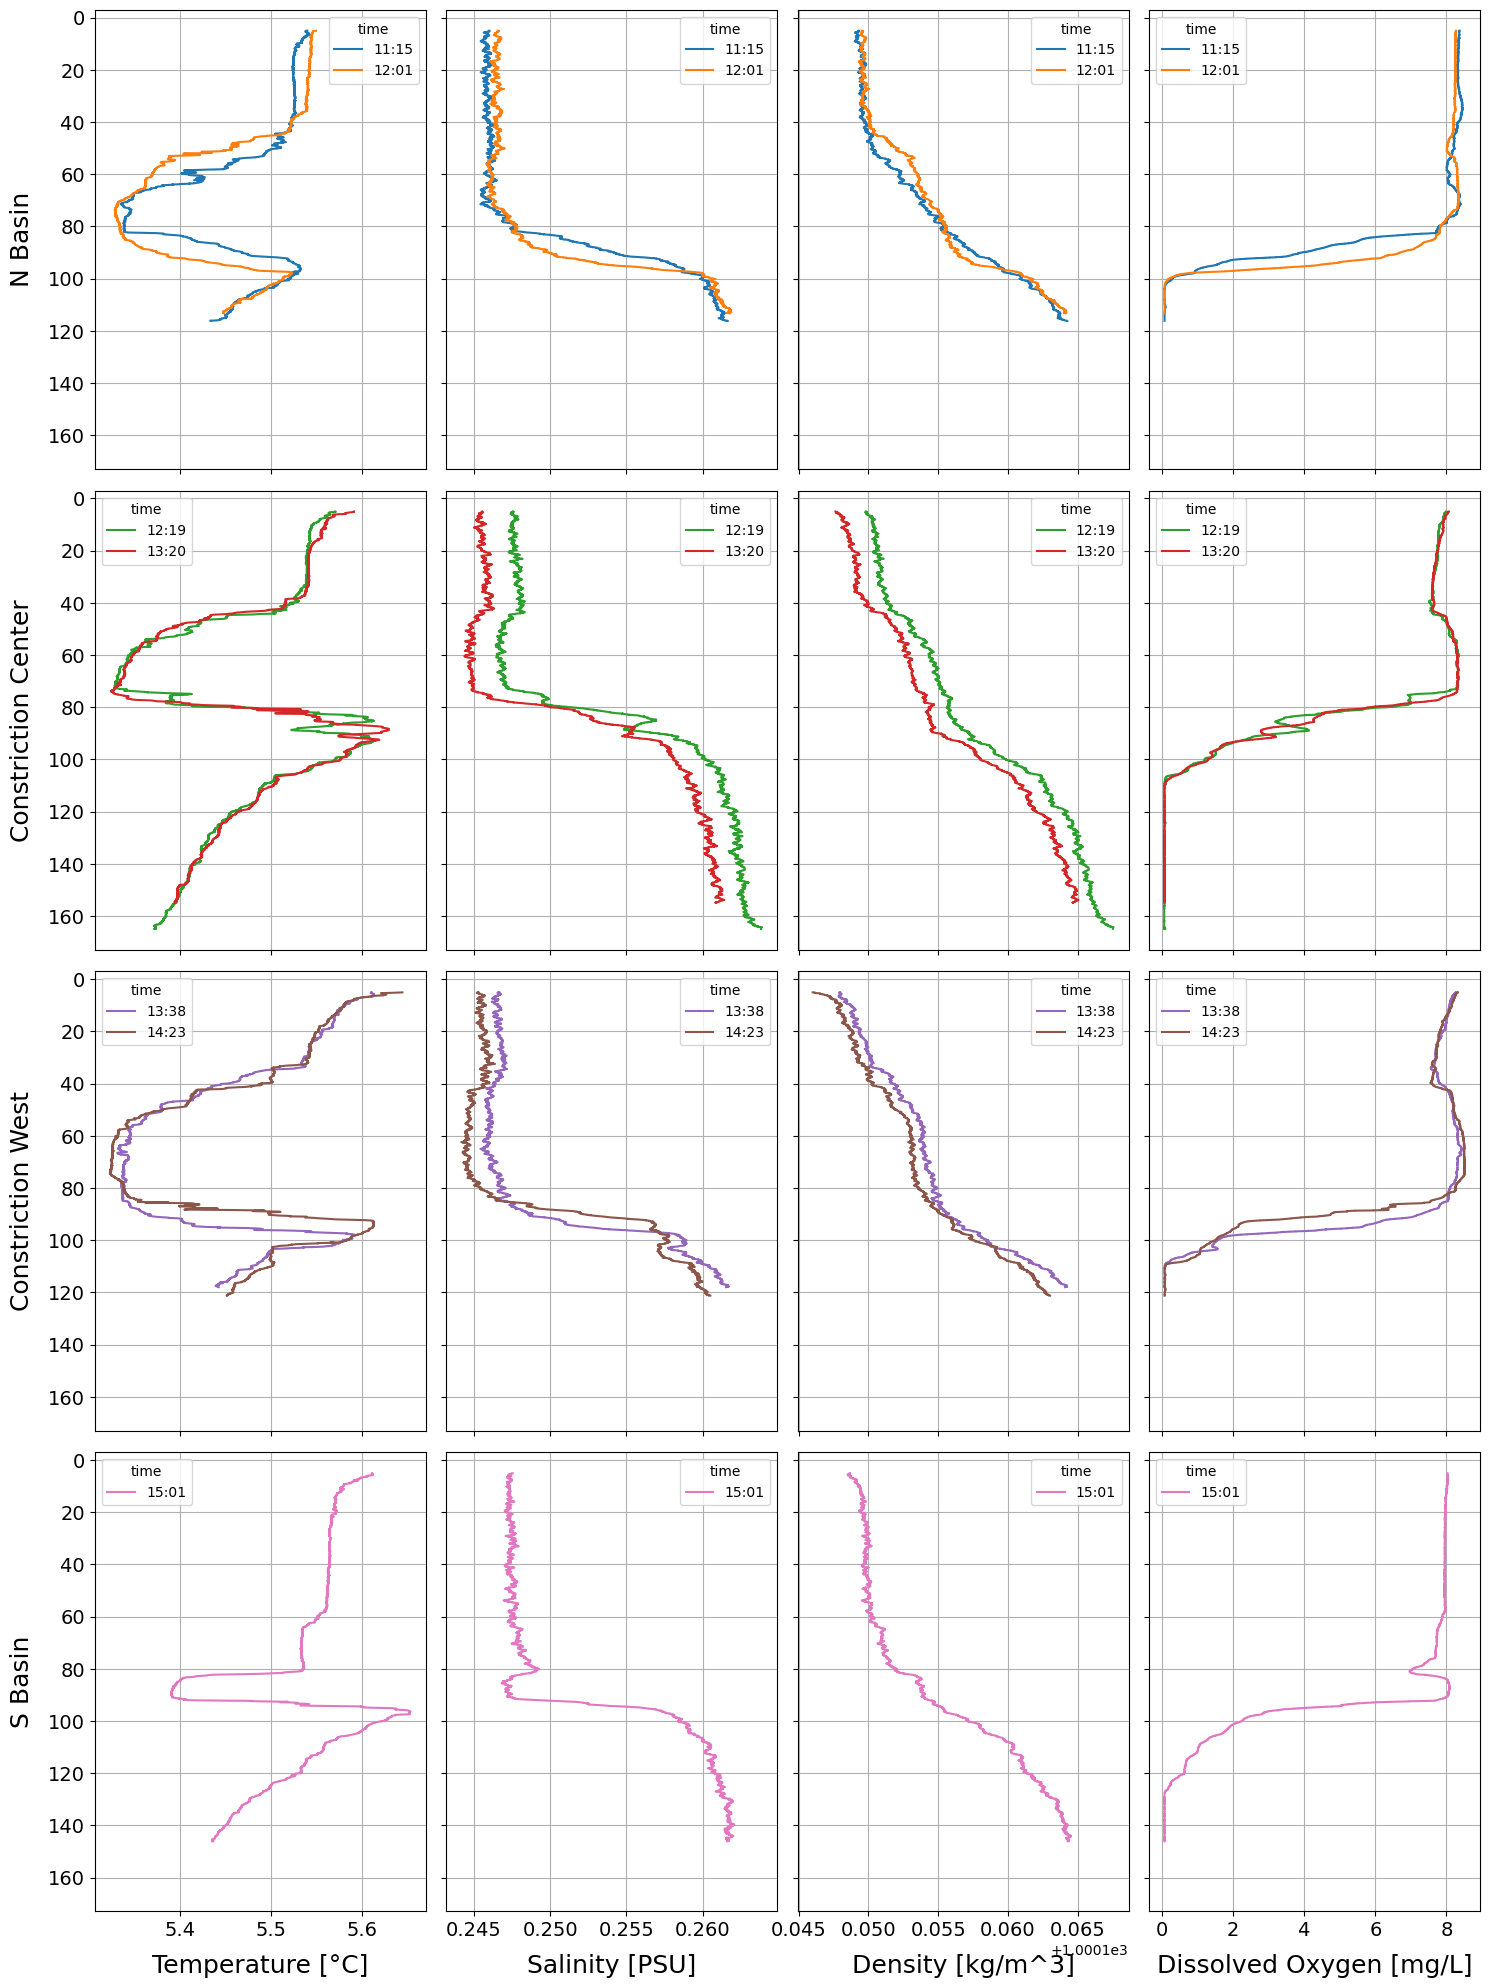

In [170]:
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(15, 20), sharey=True, sharex='col')
palette = sns.color_palette('tab10', n_colors=7)

for name, dat in data.groupby('name'):
    if name == 'VMPN':
        i = 0
        p = palette[:2]
    elif name == 'VMPC':
        i = 1
        p = palette[2:4]
    elif name == 'VMPW':
        i = 2
        p = palette[4:6]
    elif name == 'VMPS':
        i = 3
        p = palette[6:]
    else:
        continue

    dat = dat.query('depth > 5')
    # temperature
    sns.lineplot(dat, x='temp', y='depth', orient='y', hue='time', palette=p, ax=ax[i, 0])

    # salinity
    sns.lineplot(dat, x='salin', y='depth', orient='y', hue='time', palette=p, ax=ax[i, 1])

    # density
    sns.lineplot(dat, x='rho', y='depth', orient='y', hue='time', palette=p, ax=ax[i, 2])

    # dissolved oxygen
    sns.lineplot(dat, x='do', y='depth', orient='y', hue='time', palette=p, ax=ax[i, 3])
    
ax[3, 0].set_xlabel('Temperature [°C]', fontsize=18, labelpad=10)
ax[3, 1].set_xlabel('Salinity [PSU]', fontsize=18, labelpad=10)
ax[3, 2].set_xlabel('Density [kg/m^3]', fontsize=18, labelpad=10)
ax[3, 3].set_xlabel('Dissolved Oxygen [mg/L]', fontsize=18, labelpad=10)
ax[0, 0].set_ylabel('N Basin', fontsize=18, labelpad=10)
ax[1, 0].set_ylabel('Constriction Center', fontsize=18, labelpad=10)
ax[2, 0].set_ylabel('Constriction West', fontsize=18, labelpad=10)
ax[3, 0].set_ylabel('S Basin', fontsize=18, labelpad=10)

for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        ax[i, j].tick_params(labelsize=14)
        ax[i, j].grid()

ax[0, 0].invert_yaxis()
plt.tight_layout()
plt.show()